# EDA: Check if jawiki edits correlate with time:
(Weekends, time of day, Japanese holidays, lagged edits.)

## Import and Clean

### Imports and working directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from zoneinfo import ZoneInfo
from dateutil.tz import gettz
from dateutil.parser import isoparse

In [2]:
# Use the notebooks directory containing this notebook as working directory
home_path = str(Path.home())
os.chdir(home_path + '/git/predwikt/notebooks')

### Get the wiki data in pandas

In [3]:
# Get the schema description & column names (see 1.02 for more detail)
schema_df = pd.read_csv('../data/external/mediawiki_history_schema.tsv', delimiter='\t')
mw_hist_colnames = list(schema_df.col_name)[:-1]
usecols = ['event_entity', 'event_timestamp', 
           'event_user_is_bot_by_historical', 'revision_id']

**Selection of columns:**
- Only picked the necessary columns to:
    - Drop bot edits (event_user_is_bot_by_historical)
    - Select only "revision-type" edits (event_entity)
    - Keep a meaningful index (revision_id)
    - Timestamp (event_timestamp)

In [4]:
# Get Data
df = pd.read_csv('../data/raw/2021-10.jawiki.2021.tsv', 
                 delimiter='\t', names=mw_hist_colnames, header=None, usecols=usecols
                 ,nrows=1000000) # 
# Remove bot records
df = df[df.event_user_is_bot_by_historical.isna()]
# Keep only 'revision' edits
df = df[df.event_entity.isin(['revision'])]
# Set index as revision_id
df = df.set_index('revision_id')

### Convert to Japanese timezone

In [5]:
df['t_ja'] = df.event_timestamp.map(isoparse).dt.tz_localize('UTC').dt.tz_convert('Asia/Tokyo')

### Turn weekdays into dummy variables, add to df

In [6]:
weekdays_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
weekdays_str = df.t_ja.dt.weekday.map(weekdays_dict)
df = df.join(pd.get_dummies(weekdays_str))

## Count and Plot by Day, Weekday, Holidays

### Count edits by Day, Weekday

In [7]:
df['ymd'] = df.t_ja.dt.date
day_data = df.groupby('ymd').sum().sort_index()

In [8]:
day_data['each_day'] = (
    day_data[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .sum(axis=1)
)

In [ ]:
day_data.to_csv('../data/interim/ja_day_data.csv')

### Plot Edits by Day, Weekday

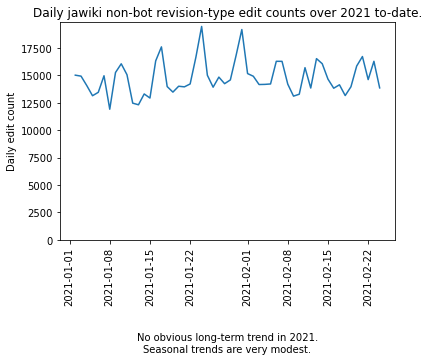

In [10]:
day_data['each_day'].iloc[1:-1].plot()
plt.xticks(rotation=90)
plt.title('Daily jawiki non-bot revision-type edit counts over 2021 to-date.')
plt.xlabel('\n\n'
           'No obvious long-term trend in 2021.\n'
           'Seasonal trends are very modest.')
plt.ylabel('Daily edit count')
plt.ylim(0,)
plt.show()

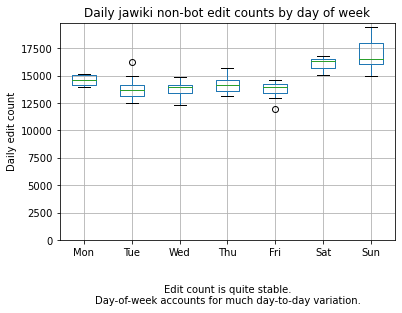

In [11]:
(day_data
 [['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
 .iloc[1:-1]
 .replace(0, np.nan)
 .boxplot()
)
plt.title('Daily jawiki non-bot edit counts by day of week')
plt.xlabel('\n\n'
           'Edit count is quite stable.\n'
           'Day-of-week accounts for much day-to-day variation.')
plt.ylabel('Daily edit count')
plt.ylim(0,)
plt.show()

### Count Edits by Hour, Weekday

In [12]:
df['hour'] = df.t_ja.dt.hour

In [13]:
total_days = (df.ymd.max() - df.ymd.min()).days #305
hour_data = (
    df.groupby('hour')
    .sum()
    .sort_index()
    [['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .divide(total_days/7)
)

### Plot edits by Hour, Weekday

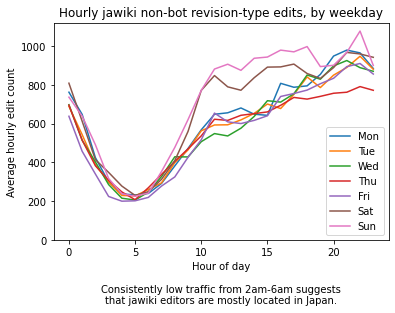

In [14]:
hour_data.plot()
plt.title('Hourly jawiki non-bot revision-type edits, by weekday')
plt.xlabel('Hour of day\n'
           '\n'
           'Consistently low traffic from 2am-6am suggests\n'
           'that jawiki editors are mostly located in Japan.')
plt.ylabel('Average hourly edit count')
plt.ylim(0,)
plt.show()

### Get Japan's holidays

In [15]:
holidays = pd.read_csv(
    home_path + '/git/predwikt/data/external/Japan_holidays.tsv', 
    delimiter='\t', usecols = ['Date', 'Name', 'Type'])
holidays['Date'] = (
    holidays.Date
    .apply(lambda x: pd.to_datetime(x, format='%d %b'))
    .apply(lambda x: x.replace(year = 2021))
)
holidays['Weekday'] = holidays.Date.dt.weekday.map(weekdays_dict)
holidays['Date'] = holidays.Date.dt.date
holidays = holidays.rename(columns={'Name':'holiday_name'})

In [16]:
df['Date'] = df.t_ja.dt.date

In [17]:
df = df.join(holidays.loc[holidays.Type == 'National holiday']
        .loc[:, ['Date','holiday_name']]
        .set_index('Date'),
        on='Date')
df['holiday'] = df.holiday_name.notnull()

In [18]:
num_holidays = df[['Date', 'holiday']].loc[df.holiday == True].drop_duplicates().count()[0]

In [19]:
hour_data_holidays = (
    df.loc[df.holiday]
    .groupby('hour')
    .sum()
    .loc[:,'holiday']
    .sort_index()
    .divide(num_holidays)
)
hour_data = hour_data.join(hour_data_holidays)

### Plot Edits on Holidays

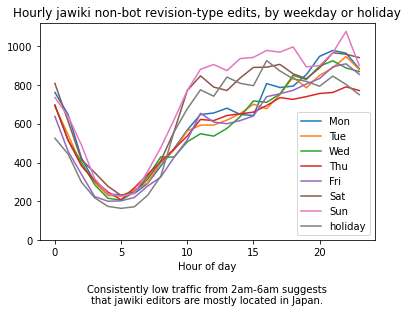

In [20]:
fig = plt.figure()
ax = fig.gca()
hour_data.plot(ax=ax)
ax.set_title('Hourly jawiki non-bot revision-type edits, by weekday or holiday')
ax.set_xlabel('Hour of day\n'
              '\n'
              'Consistently low traffic from 2am-6am suggests\n'
              'that jawiki editors are mostly located in Japan.')
ax.set_label('Average hourly edit count')
ax.set_ylim(0,)
plt.show()

## Check correlation with lagged edits

In [22]:
day_data2 = df.groupby('ymd').sum().sort_index()
day_data2['each_day'] = (
    day_data2[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
    .sum(axis=1)
)
# day_data2.to_csv('../data/interim/ja_day_data.csv')

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,each_day
ymd,,,,,,,,
2021-01-01,10577.0,0.0,0.0,0.0,0.0,0.0,0.0,10577.0
2021-01-02,0.0,0.0,15017.0,0.0,0.0,0.0,0.0,15017.0
2021-01-03,0.0,0.0,0.0,14929.0,0.0,0.0,0.0,14929.0
2021-01-04,0.0,14067.0,0.0,0.0,0.0,0.0,0.0,14067.0
2021-01-05,0.0,0.0,0.0,0.0,0.0,13141.0,0.0,13141.0
2021-01-06,0.0,0.0,0.0,0.0,0.0,0.0,13450.0,13450.0
2021-01-07,0.0,0.0,0.0,0.0,14963.0,0.0,0.0,14963.0
2021-01-08,11910.0,0.0,0.0,0.0,0.0,0.0,0.0,11910.0
2021-01-09,0.0,0.0,15259.0,0.0,0.0,0.0,0.0,15259.0
